In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import style
import seaborn as sns

from scipy.stats import poisson
from scipy.stats import gamma
from scipy.integrate import odeint

from tqdm import tqdm

from numpy import linalg as LA


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

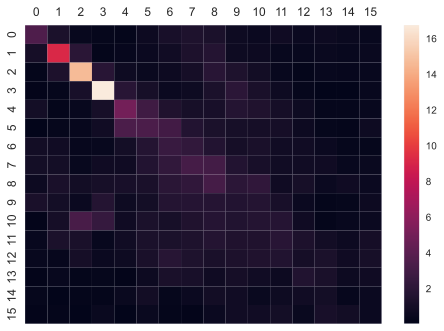

In [3]:
df = pd.read_csv('data/data_provinces.csv').drop('Unnamed: 0', axis = 1)
c_matrix = pd.read_csv('data/italian_matrix.csv').drop('Unnamed: 0', axis = 1)
c_matrix = c_matrix.values

style.use('seaborn')

plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, \
                bottom=False, top = False, labeltop=True)
ax = sns.heatmap(c_matrix)

## Compute largest eigenvalue of the contact matrix
s_r = max(LA.eigvals(c_matrix))

In [6]:
# Calculate age distribution in excell based on Italian statistics - import results
n_df = pd.read_csv('data/age_structure.csv')
n = n_df["Sum of Total2"].values
n.sum()

0.9999999980000001

In [7]:
# Define a simple SIR with age strcture 

def SIR_eq(INPUT,t, n, BETA, g, l):    
    Y=np.zeros((16*3))
    S, I, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:], 0))
    N = S + I + R
    k= 16
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i] # The transmission between people
        Y[i] = l[i]*S[i-1] - SUM - l[i+1]*S[i] # Susceptible
        Y[(k+i)] = l[i]*I[i-1] + SUM - l[i+1]*I[i] - g*I[i] # Infected
        Y[(2*k+i)] = l[i]*R[i-1] + g*I[i] - l[i+1]*R[i] # Removed
    return Y  # For odeint

In [8]:
# Define our parameters

d = 14 # duration of COVID
# We assume average life expectancy of 70 years and uniform distribution of birthdays over the year 
l = np.hstack((0,np.ones(15)/(5*365),0)) # Growth of people between categories

# INITIALIZE POPULATION 
N = 80724

S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
R0 = np.array([0]*16)

INPUT = np.hstack((S0, I0, R0))

In [9]:
# Model calibration - 1st Define required functions = MLE
def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) 
    return llkh

In [10]:
# Model calibration loop - using both MLE and RMSE
R0s = np.arange(1.5, 2.5, 0.001) # Range of R0 we explore 

T = 73 # Days we fit 
steps_per_t = 1
t = np.arange(1, T+1, 1/steps_per_t) 

true_data = df['VA'][:72] # The observed data 

# Data storing 
I_hats = []
MSEs = []
llkhs = []

for R0 in tqdm(R0s):
    beta = R0/(d*s_r)
    BETA = beta*c_matrix
    g = 1/d

    RES = odeint(SIR_eq, INPUT ,t, args=(n, BETA, g, l))
    T_S, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:].sum(axis=1)
    I_daily = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])

    I_hats.append(I_daily)
    MSEs.append(np.sqrt(sum((I_daily-true_data)**2)/len(true_data)))
    llkhs.append(compute_loglikelihood(true_data,I_daily))
    
cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'llkh': llkhs, 'I_hat': I_hats})

best_model_MSE = cal.loc[cal['MSE'].idxmin()]
print('BEST MODEL MSE: RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
best_model_llkh = cal.loc[cal['llkh'].idxmax()]
print('BEST MODEL LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh['R0'], 4), best_model_llkh['llkh']))

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-7-00534ddc20af>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = l[i]*S[i-1] - SUM - l[i+1]*S[i] # Susceptible
<ipython-input-7-00534ddc20af>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*I[i-1] + SUM - l[i+1]*I[i] - g*I[i] # Infected
 32%|███▏      | 321/1000 [00:10<00:21, 31.40it/s]


KeyboardInterrupt: 

<ipython-input-96-b60080404c0e>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


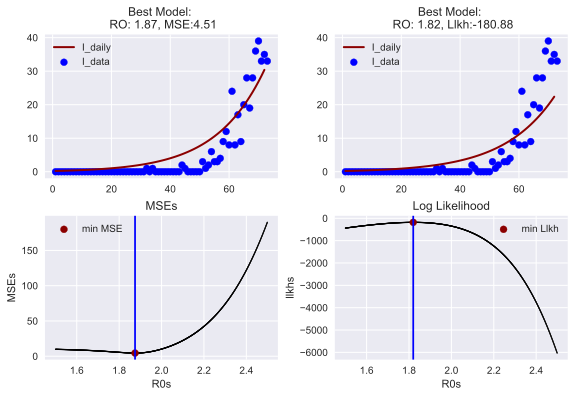

In [96]:
# Plotting calibration results

fig, axs = plt.subplots(2,2, facecolor='w')
axs[0,0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
axs[0,0].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,0].plot(t[:-1] ,best_model_MSE['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[0,1].set_title('Best Model: \n RO: {}, Llkh:{}'.format(round(best_model_llkh['R0'], 2), round(best_model_llkh['llkh'],2)))
axs[0,1].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,1].plot(t[:-1] ,best_model_llkh['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[1,0].set_title('MSEs')
axs[1,0].scatter(cal['R0'], cal['MSE'], color = 'k' , s =1 )
axs[1,0].scatter(best_model_MSE['R0'], best_model_MSE['MSE'], color = 'darkred' , s =50, label='min MSE' )
axs[1,0].axvline(x= best_model_MSE['R0'], ymin=0, ymax=2, c= 'b')
axs[1,0].set_xlabel('R0s')
axs[1,0].set_ylabel('MSEs')
    
axs[1,1].set_title('Log Likelihood')
axs[1,1].scatter(cal['R0'], cal['llkh'], color = 'k' , s =1 )
axs[1,1].scatter(best_model_llkh['R0'], best_model_llkh['llkh'], color = 'darkred' , s =50, label='min Llkh' )
axs[1,1].axvline(x= best_model_llkh['R0'], ymin=0, ymax=2, c= 'b')
axs[1,1].set_xlabel('R0s')
axs[1,1].set_ylabel('llkhs')

for i in range(2):
    for z in range(2):
        axs[i,z].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[i,z].spines[spine].set_visible(False)
        
fig.tight_layout()
fig.show()

In [97]:
# Visualzing the model using calibrated R0

T = 500 # Period used for data visualization
steps_per_t = 1 # We assume one step is quivalent to one day 
t = np.arange(1, T+1, 1/steps_per_t) 

C_R0 = best_model_MSE['R0']
beta = C_R0/(d*s_r)
BETA = beta*c_matrix
g = 1/d

RES = odeint(SIR_eq, INPUT ,t, args=(n, BETA, g, l))
C_R0

<ipython-input-92-00534ddc20af>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = l[i]*S[i-1] - SUM - l[i+1]*S[i] # Susceptible
<ipython-input-92-00534ddc20af>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*I[i-1] + SUM - l[i+1]*I[i] - g*I[i] # Infected


1.8749999999999587

In [98]:
# Model over entire population
S, I, R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:].sum(axis=1)

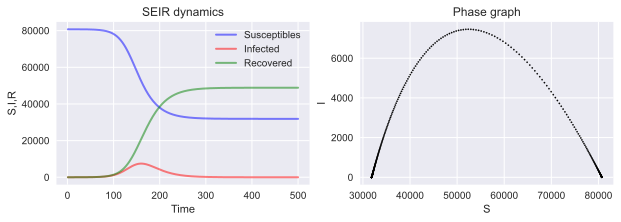

In [99]:
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(10,3))

ax = axs[0]
ax.set_title('SEIR dynamics')

ax.plot(t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

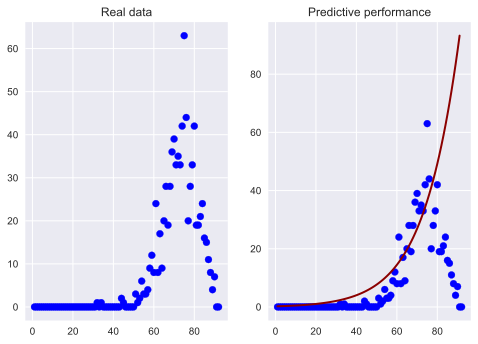

In [100]:
# Predictive performance
fig, ax = plt.subplots(1, 2)
ax[1].set_title('Predictive performance')
ax[1].scatter(t[:len(df['VA'][:])], df['VA'][:], color = 'b', label = 'I_data')
I = I[:len(df['VA'][:])]
R = R[:len(df['VA'][:])]
new_dayly = (I[1:]+R[1:])-(I[:-1]+R[:-1])
ax[1].plot(t[:len(new_dayly)] ,new_dayly, alpha=1, lw=2, label='I_daily', color = 'darkred')

ax[0].set_title('Real data')
ax[0].scatter(t[:len(df['VA'][:])], df['VA'][:], color = 'b', label = 'I_data')

# As we can see this simplistic SIR model fails to capture the measures implemented  
# by the goverment that helped tame the spread of COVID

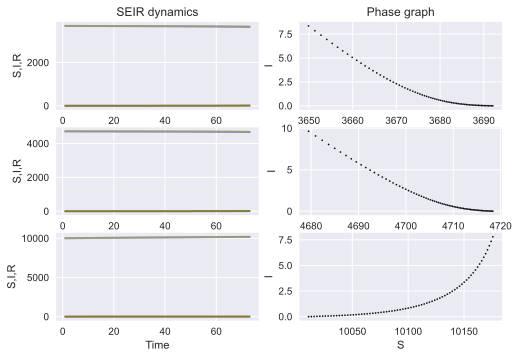

In [11]:
# Comparing the spread of COVID accross age groups 

# Young population 
S_y, I_y, R_y = RES[:,1], RES[:,17], RES[:,33]
S_m, I_m, R_m = RES[:,7], RES[:,23], RES[:,39]
S_o, I_o, R_o = RES[:,15], RES[:,31], RES[:,47]

S = np.hstack((S_y, S_m, S_o)).reshape(3,-1)
I = np.hstack((I_y, I_m, I_o)).reshape(3,-1)
R = np.hstack((R_y, R_m, R_o)).reshape(3,-1)

fig, ax = plt.subplots(3,2, facecolor='w')

for i in range(3):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R)[i,:], 'y', alpha=0.5, lw=2)

    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('S,I,R')

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[i,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

# Ilogical  behaviour young people going down old people florishing - due to simple assumptions 